In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic
from schemdraw import dsp

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

import json
from IPython.display import display, HTML
from IPython.display import Javascript

display(HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.5.0/chart.min.js" integrity="sha512-asxKqQghC1oBShyhiBwA+YgotaSYKxGP1rcSYTDrB0U6DxwlJjU59B67U8+5/++uFjcuVM8Hh5cokLjZlhm3Vg==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
'''))

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ;
    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__name__ = name
        self.__R = R
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        self.R1.resistance = self.__R * w
        self.R2.resistance = self.__R * (1.0-w)
        

# about

In the ringmodulator article various discrete differential amplifiers were analysed. We will now an OTA can be replaced with a discrete circuit.


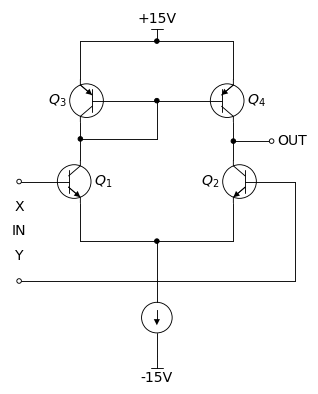

In [3]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)


d += ( Q1 := elm.BjtNpn( label='$Q_1$', circle=True))
d += elm.Line("up").length(d.unit/2)
d += ( Q3 := elm.BjtPnp(circle=True).anchor("collector").right().reverse().label('$Q_3$', 'left') )
d += elm.Line().up().at(Q3.emitter).length(d.unit/2)
d += elm.Line().right().length(d.unit)
d += ( vdd := elm.Vdd(label="+15V") )

d += elm.Line().at(Q3.base).right().tox(vdd.end)
d += elm.Line().down().length(d.unit/2)
d += elm.Line().left().tox(Q3.collector)
d += elm.Dot()

d += ( IN_X := elm.Line("left", l=d.unit/2, xy=Q1.base))
d += elm.Dot('left', open=True)

d += ( L_Q1_emmitter := elm.Line("down",  xy=Q1.emitter, l=d.unit/2))
d += elm.Line("right", l=d.unit)
d += elm.Dot()
d.push()
d += elm.Line("right", l=d.unit)
d += elm.Line("up", l=d.unit/2)
d += ( Q2 := elm.BjtNpn("right", lftlabel='$Q_2$', anchor="emitter", circle=True, reverse=True))
d += elm.Line().up().at(Q2.collector).length(d.unit/4)
d.push()
d += elm.Line().up().length(d.unit/4)
d += ( Q4 := elm.BjtPnp(circle=True).anchor("collector").right().label('$Q_4$', loc='right') )
d += elm.Line().up().at(Q4.emitter).length(d.unit/2)
d += elm.Line().left()
d += elm.Dot()

d.pop()
d += elm.Dot()
d += elm.Line().right().length(d.unit/2)
d += elm.Dot('left', open=True).label('OUT', loc='right')

d.pop()
d += elm.Line().length(d.unit/2).down()
d += elm.SourceI().down()
d += elm.Vss().label('-15V', loc='bottom')

d += elm.Line().at(Q4.base).left().tox(vdd.end)
d += elm.Dot()

d += (elm.Line("right", xy=Q2.base, l=d.unit/2))
d += (elm.Line("down", l=d.unit*1.3))
d += ( IN_Y := elm.Line().left().tox(IN_X.end))
d += elm.Dot('left', open=True)

d += (elm.Gap('down', xy=IN_X.end, toy=IN_Y.end, label=['X', 'IN', 'Y']))
d.draw()

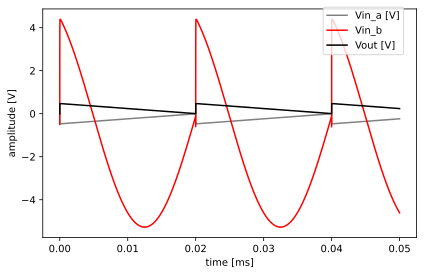

In [20]:
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

circuit = parser.build_circuit(ground=5)
circuit.include(spice_library['BC846B']) #NPN
circuit.include(spice_library['BC556B']) #PNP
circuit.include(spice_library['TL072'])

circuit.V('1', '+15V', circuit.gnd, 'DC 12')
circuit.V('2', '-15V', circuit.gnd, 'DC -12')
circuit.V('3', '/IN', circuit.gnd, 'DC 5 Pulse(0 1 0 0 20m 0.1m 20m)')

circuit.R(101, '/2_1', 'R', 0@u_kΩ)
circuit.R(102, '/2_2', 'R', 0@u_kΩ)
circuit.R(103, '/2_3', 'R', 0@u_kΩ)
circuit.R(104, 'R', circuit.gnd, 100@u_kΩ)
circuit.R(105, '/2_4', '-15V', 0@u_kΩ)
circuit.R(106, '/2_5', '+15V', 0@u_kΩ)
circuit.R(107, '/2_6', '+15V', 10@u_kΩ)
circuit.R(108, '/2_6', circuit.gnd, 10@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=50@u_ms)
    

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(analysis['/1_1'].abscissa, analysis['/1_1'], color='Grey')
ax1_buffer.plot(analysis['/OUT'].abscissa, analysis['/OUT'], color='Red')
ax1_buffer.plot(analysis['/1_5'].abscissa, analysis['/1_5'], color='Black')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()



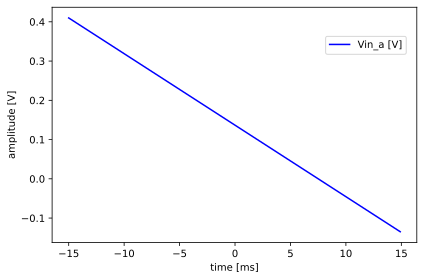

In [6]:
circuit = Circuit('input buffer')
circuit.include(spice_library['BC846B']) #NPN
circuit.include(spice_library['BC556B']) #PNP
circuit.include(spice_library['TL072'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN_a', circuit.gnd, 'DC 5V')
circuit.V('4', 'IN_b', circuit.gnd, 'DC 0V AC 0V SIN(5 1 100)')
CV = circuit.V('5', 'CV', circuit.gnd, 'DC 5 AC 0V')

#the opamps
#                     NON-INVERTING INPUT
#                     |           INVERTING INPUT
#                     |           |             POSITIVE POWER SUPPLY
#                     |           |             |       NEGATIVE POWER SUPPLY
#                     |           |             |       |       OUTPUT
#                     |           |             |       |       |
circuit.X(1, 'TL072', circuit.gnd,'X1n',      '+15V', '-15V', 'X1o')
circuit.R(1, 'CV', 'X1n', 100@u_kΩ)
circuit.R(2, '-15V', 'X1n', 200@u_kΩ)
circuit.R(3, 'X1o', 'X1n', 51@u_kΩ)
circuit.R(4, 'X1o', 'OUT', 27@u_kΩ)
circuit.R(5, 'OUT', circuit.gnd, 1@u_kΩ)

x = []
res = []
for v in np.arange(-15, +15, 0.1) :
    CV.dc_value = v 
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis  = simulator.operating_point()
    res.append(analysis['OUT'])
    x.append(v)

fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(x, res, color='Blue')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()


In [7]:
#ina, inb, vdd, vee

class OTA(SubCircuitFactory):
    __name__ = 'OTA'
    __nodes__ = ('n1', 'n2', 'n3', 'n4', 'out' )
    __R = 100@u_kΩ;
    def __init__(self, name='voltage_divider'):
        self.__name__ = name
        super().__init__()
        
        #Q NC NB NE model
        self.BJT('1', 'NC1', 'n1', 'NE', model="BC846B")
        self.BJT('2', 'NC2', 'n2', 'NE', model="BC846B")
        self.BJT('3', 'NC1', 'NC1', 'n3', model="BC556B")
        self.BJT('4', 'NC2', 'NC1', 'n3', model="BC556B")
        self.I(1, 'n4', 'NE', 0.1@u_mA)
        

# *references*

- [ESP](https://sound-au.com/articles/state-variable.htm) State Variable Filters

- https://www.electronics-tutorials.ws/de/filtern/zustandsvariablenfilter.html
- https://electro-music.com/forum/topic-69749-50.html
- https://www.schmitzbits.de/wasp.html
- https://www.elby-designs.com/webtek/cgs/cgs30/cgs30_bpf.html
- https://hackaday.com/2015/03/25/logic-noise-filters-and-drums/
- http://aeeprojects.blogspot.com/2011/09/filters-with-cd4069.html
- https://electro-music.com/forum/phpbb-files/svf_147.jpg
- https://electro-music.com/forum/topic-69887.html